In [1]:
import matplotlib.pyplot as plt
import sys
import os

sys.path.append('/usr/local/lib/python3.7/site-packages/')
 
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool, cv
from tqdm import tqdm
# from sklearn.ensemble import RandomForestRegressor
# from boruta import BorutaPy

%matplotlib inline

In [2]:
model_ki = CatBoostRegressor() 
model_ki.load_model('../models/ki_all_catboost_reg_mae_0.670_0.721')
model_ki.get_params()

{'loss_function': 'MAE',
 'use_best_model': True,
 'od_wait': 100,
 'verbose': 0,
 'iterations': 20000,
 'l2_leaf_reg': 1,
 'task_type': 'GPU',
 'random_seed': 42,
 'learning_rate': 0.1}

In [3]:
data_df = pd.read_csv('../data/2020-06_Enamine_screening_compounds_in-stock_SMILES.smiles', usecols=[0], sep='\s+')
data_df.shape

(2761292, 1)

In [7]:
train_df = pd.read_csv('../data/fasta-smiles-ki-catboost/fasta_pbm_physchem_smiles_ecfp4_ki_with_strings.csv')
train_df.shape

(417047, 2268)

In [20]:
ligand_cols = list(train_df.filter(like='Ligand ECFP4').columns)
ligand_cols.extend(['FASTA', 'Ligand SMILES', 'Ki (nM)'])

In [8]:
human_thrombin_fasta = 'MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE'


In [24]:
human_thrombin_fasta_features = train_df[train_df.FASTA == human_thrombin_fasta].drop(columns=ligand_cols)

In [34]:
human_thrombin_fasta_features.head()

CV0   CV1   CV2   CV3   CV4  CV5   CV6   CV7   CV8   CV9  ...  \
4423  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4424  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4425  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4426  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4427  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   

      _HydrophobicityD2001  _HydrophobicityD2025  _HydrophobicityD2050  \
4423                 0.322                23.473                45.177   
4424                 0.322                23.473                45.177   
4425                 0.322                23.473                45.177   
4426                 0.322                23.473                45.177   
4427                 0.322                23.473                45.177   

      _HydrophobicityD2075  _HydrophobicityD2100  _HydrophobicityD3001  \
4423                72.508                99.839                 0.161   
4424                72.508                99.839                 0.161   
4425                72.508                99.839                 0.161   
4426                72.508                99.839                 0.161   
4427                72.508                99.839                 0.161   

      _HydrophobicityD3025  _HydrophobicityD3050  _HydrophobicityD3075  \
4423                25.241                54.823                76.206   
4424                25.241                54.823                76.206   
4425                25.241                54.823                76.206   
4426                25.241                54.823                76.206   
4427                25.241                54.823                76.206   

      _HydrophobicityD3100  
4423                99.678  
4424                99.678  
4425                99.678  
4426                99.678  
4427                99.678  

[5 rows x 217 columns]

In [31]:
human_thrombin_fasta_features.values[0].shape

(217,)

In [48]:
human_thrombin_fasta_features_list = human_thrombin_fasta_features.values[0].tolist()

In [52]:
def make_inference(row):
    try:
        m = Chem.MolFromSmiles(row)
        fp = AllChem.GetMorganFingerprintAsBitVect(m,2,invariants=[1]*m.GetNumAtoms())
        array = np.zeros((0, ), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, array)
        features = human_thrombin_fasta_features_list.copy()
        features.extend(array.tolist())
        pred = 10**model_ki.predict(features)
        return pred
    except Exception as e:
        print(e)
        return np.nan

In [ ]:
%%time

with open('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.all', 'w') as results:
    for index, row in tqdm(data_df.iterrows()):
        pred = make_inference(row.smiles)
        results.write("{}, {}\n".format(row.smiles, pred))

2560659it [5:00:41, 160.18it/s]

# nsmallest

In [2]:
catboost_ki = pd.read_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.master',
                         header=None,
                         low_memory=False,
                         names=['SMILES', 'Ki (nM)'])

In [83]:
catboost_ic50 = pd.read_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ic50.master',
                         header=None,
                         low_memory=False,
                         names=['SMILES', 'IC50 (nM)'])

In [5]:
! head -5 ../inference/bert-inference-thrombin-ki/smiles_2_5_M_ki.csv

smiles	prediction (Ki)
O=S(=O)(Nc1ccc2c(c1)OCO2)c1ccc(Cl)cc1	4.045372
O=S(=O)(Nc1ccc2c(c1)OCO2)c1ccc(Br)cc1	4.0564556
O=[N+]([O-])c1ccc(S(=O)(=O)Nc2ccc3c(c2)OCO3)cc1	4.808396
O=S(=O)(Nc1ccc2c(c1)OCO2)c1ccc2ccccc2c1	3.9362938


In [10]:
bert_ki = pd.read_csv('../inference/bert-inference-thrombin-ki/smiles_2_5_M_ki.csv',
                         low_memory=False,
                         sep='\t',
                         skiprows=1,
                         names=['SMILES', 'Ki (nM)'])

In [11]:
bert_ki.head()

SMILES   Ki (nM)
0            O=S(=O)(Nc1ccc2c(c1)OCO2)c1ccc(Cl)cc1  4.045372
1            O=S(=O)(Nc1ccc2c(c1)OCO2)c1ccc(Br)cc1  4.056456
2  O=[N+]([O-])c1ccc(S(=O)(=O)Nc2ccc3c(c2)OCO3)cc1  4.808396
3          O=S(=O)(Nc1ccc2c(c1)OCO2)c1ccc2ccccc2c1  3.936294
4                O=S(=O)(Nc1ccc2c(c1)OCO2)c1ccccc1  4.064646

In [12]:
catboost_ki = catboost_ki.dropna()
catboost_ic50 = catboost_ic50.dropna()
bert_ki = bert_ki.dropna()

In [84]:
catboost_ki['Ki (nM)'] = catboost_ki['Ki (nM)'].astype(float)
catboost_ic50['IC50 (nM)'] = catboost_ic50['IC50 (nM)'].astype(float)
bert_ki['Ki (nM)'] = bert_ki['Ki (nM)'].astype(float)

In [85]:
catboost_ki_top = catboost_ki.nsmallest(4000, 'Ki (nM)')
catboost_ic50_top = catboost_ic50.nsmallest(4000, 'IC50 (nM)')
# bert_ki_top = bert_ki.nsmallest(1000, 'Ki (nM)')

In [48]:
top100 = set(catboost_ki_top.SMILES).intersection(set(catboost_ic50_top.SMILES))
# print(len(set(catboost_ki_top.SMILES).intersection(set(bert_ki_top.SMILES))))
# print(len(set(bert_ki_top.SMILES).intersection(set(catboost_ic50_top.SMILES))))

In [52]:
top100

{'CC(C)(C)[C@@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)NCCCn1nc2CCCCn2c1=O)n1cc(nn1)C1CC1',
 'CC(C)=CCOc1cccc(c1)C(=O)N1[C@H]2CCO[C@H]2C[C@H]1C(=O)N1CCCC1',
 'CC(C)Cn1cccc(C(=O)N2CC(C)(C)O[C@@H]3COC[C@@H]23)c1=O',
 'CC(C)n1cc(cc(C#N)c1=O)C(=O)c1cc(F)ccc1OCc1nc(N)nc(Nc2ccccc2C)n1',
 'CC(Cn1ccnc1)NC(=O)C1CC2CCCCC2N1C(=O)c1cccc(Cl)c1',
 'CC1(N(Cc2nc(N)nc(Nc3ccc(F)cc3)n2)C(=O)N(Cc2nc(N)nc(Nc3ccc(F)cc3)n2)C1=O)c1ccc2OCCOc2c1',
 'CC1CCCN(C1)C(=O)c1cccn(Cc2cccc(C)c2)c1=O',
 'CC1CCCN(Cn2nc(COc3ccc(Cl)cc3)n(-c3ccccc3)c2=S)C1',
 'CC1CN(CC2CCCN2C(=O)CCc2c(C)nc3c4ccccc4nn3c2C)CC(C)O1',
 'CC1CN(CCN1)C(=O)c1cccn(Cc2cccc(C)c2)c1=O',
 'CC1COC2(CCN(CC2)C(=O)c2cccn(Cc3cccc(C)c3)c2=O)O1',
 'CCC(CC)N(CC(C)C)C(=O)c1cccn(Cc2cccc(C)c2)c1=O',
 'CCC1(NC(=O)N(CN2CCc3sccc3C2c2ccccc2)C1=O)c1cccc(Cl)c1',
 'CCC1CCCCN1C(=O)c1cccn(Cc2ccccc2)c1=O',
 'CCC1CCCN(C1)C(=O)c1cccn(Cc2cccc(C)c2)c1=O',
 'CCC1CN(CCO1)C(=O)c1cccn(Cc2cccc(C)c2)c1=O',
 'CCCCC1(NC(=O)N(CC(=O)Nc2ccccc2C(=O)c2ccccc2)C1=O)c1ccc(F)cc1',
 'CCN(C1CC1)C(=O)c1cccn(C

In [53]:
count = 0
top100_list = []
for elem in iter(top100):
    top100_list.append(elem)
    count = count + 1
    if count == 100:
        break

In [55]:
len(top100_list)

100

In [57]:
catboost_ki_100 = []
for i, row in catboost_ki_top.iterrows():
    if row.SMILES in top100_list:
        catboost_ki_100.append(row['Ki (nM)'])
        
catboost_ic50_100 = []
for i, row in catboost_ic50_top.iterrows():
    if row.SMILES in top100_list:
        catboost_ic50_100.append(row['IC50 (nM)'])

In [63]:
top100_master = pd.DataFrame({'SMILES': top100_list,
                             'Ki (nM)': catboost_ki_100,
                             'IC50 (nM)': catboost_ic50_100})

In [98]:
top100_master.to_csv('../inference/top100_Ki_IC50_intersect_master.csv', index = None)

# nlargest

In [86]:
catboost_ki_top = catboost_ki.nlargest(3000, 'Ki (nM)')
catboost_ic50_top = catboost_ic50.nlargest(3000, 'IC50 (nM)')

In [87]:
bottom100 = set(catboost_ki_top.SMILES).intersection(set(catboost_ic50_top.SMILES))

In [88]:
len(bottom100)

136

In [89]:
count = 0
bottom100_list = []
for elem in iter(bottom100):
    bottom100_list.append(elem)
    count = count + 1
    if count == 100:
        break

In [91]:
len(bottom100_list)

100

In [94]:
catboost_ki_100 = []
for i, row in catboost_ki_top.iterrows():
    if row.SMILES in bottom100_list:
        catboost_ki_100.append(row['Ki (nM)'])
        
catboost_ic50_100 = []
for i, row in catboost_ic50_top.iterrows():
    if row.SMILES in bottom100_list:
        catboost_ic50_100.append(row['IC50 (nM)'])

In [95]:
bottom100_master = pd.DataFrame({'SMILES': bottom100_list,
                             'Ki (nM)': catboost_ki_100,
                             'IC50 (nM)': catboost_ic50_100})

In [96]:
bottom100_master

SMILES        Ki (nM)     IC50 (nM)
0                              CCOP(=O)(CCl)OCC  901607.742201  2.614831e+06
1                          CN(C)P(=O)(CCl)N(C)C  657324.249277  2.522738e+06
2     CN(CCOC(=O)C1CCS(=O)(=O)C1)C(=O)OC(C)(C)C  539539.365453  2.052304e+06
3      CC(C)=CC1C(C(=O)NCC2CCS(=O)(=O)C2)C1(C)C  527013.728069  1.953566e+06
4         CN(C)CCN(C)C(=O)CCCN(C)C(=O)OC(C)(C)C  443077.587175  1.506660e+06
..                                          ...            ...           ...
95  CN(C)C(=O)CNS(=O)(=O)N1CCCCC1C(=O)OC(C)(C)C  113706.547659  4.541201e+05
96         CC(C)CNC(=O)N1CCN(CC1)C(=O)OC(C)(C)C  113681.377162  4.541201e+05
97                 O=C(NCCC1CC1)C1CCS(=O)(=O)C1  112134.092532  4.504426e+05
98      CCN(CCNS(=O)(=O)N1CCOCC1)C(=O)OC(C)(C)C  111675.412968  4.471346e+05
99                    C[C@@H]1C[C@H]1S(N)(=O)=O  110503.364847  4.471159e+05

[100 rows x 3 columns]

In [97]:
bottom100_master.to_csv('../inference/bottom100_Ki_IC50_intersect_master.csv', index = None)

# BERT results analysis

In [35]:
# catboost_ki.set_index('SMILES')
# bert_ki.set_index('SMILES')
diff = bert_ki.set_index('SMILES').join(catboost_ki.set_index('SMILES'), lsuffix='_bert', rsuffix='_ctb')
# diff = pd.merge(bert_ki, catboost_ki, left_on='SMILES', right_on='SMILES')

In [37]:
diff = diff.dropna()

In [38]:
diff

Ki (nM)_bert  Ki (nM)_ctb
SMILES                                                                       
C=CCNC(=O)c1ccccc1NS(=O)(=O)N1CCc2ccccc2C1              3.755944  1524.023403
C=CCNC(=O)c1ccccc1NS(=O)(=O)c1c[nH]c2ncccc12            3.272720  1241.791115
C=CCNC(=O)c1ccccc1NS(=O)(=O)c1ccccc1                    3.617657  1640.030264
C=CCSc1ccccc1NS(=O)(=O)c1ccccc1                         3.816055  1091.969085
C=CCSc1ccccc1NS(=O)(=O)c1cccs1                          4.176366  1091.969085
...                                                          ...          ...
O=c1ccccn1Cc1ccc(NS(=O)(=O)C2=Cc3ccccc3CC2)cc1          3.374826  1168.151180
O=c1ccccn1Cc1ccc(NS(=O)(=O)c2cccs2)cc1                  4.108790  1474.628840
O=c1n(Cc2cccc(NS(=O)(=O)C3=Cc4ccccc4CC3)c2)nc2c...      2.647250   403.143785
O=c1n(Cc2cccc(NS(=O)(=O)CC3CCCO3)c2)nc2ccccn12          2.250071   127.183858
O=c1n(Cc2cccc(NS(=O)(=O)c3cn[nH]c3)c2)nc2ccccn12        2.698167   290.840189

[5253 rows x 2 columns]

In [63]:
top100.to_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.all.top100',
              index=None)

# 100 largest

In [64]:
top100largest = results_df.nlargest(100, 'Ki (nM)')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6fcf2ec10>]],
      dtype=object)

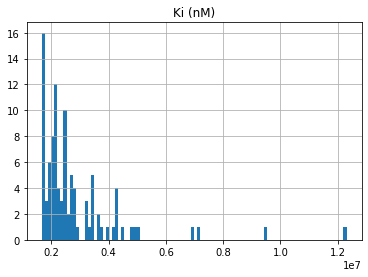

In [65]:
top100largest.hist(bins=100)

In [66]:
top100largest.head(50)

SMILES       Ki (nM)
1230770  COC(=O)c1c(CC(=O)N=c2sc3ccccc3n2C)[nH]c(C(C)=O...  1.231126e+07
2288749  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  9.517519e+06
828992   CCOC(=O)C=c1sc(=Cc2cc(OC)cc(OC)c2)c(=O)n1CC(=O...  7.120899e+06
832200   CCOC(=O)C=c1sc(=Cc2ccc(cc2)C#N)c(=O)n1CC(=O)NC...  6.886710e+06
2169069  CCOC(=O)C=c1sc(=Cc2cc(OC)cc(OC)c2)c(=O)n1CC(=O...  4.982472e+06
2288745  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  4.936689e+06
2097526    Cc1nn(CC(=O)N=c2sc3ccccc3n2C)c(C)c1[N+]([O-])=O  4.864711e+06
2288811  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  4.508168e+06
1347946  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  4.317653e+06
834107   COCC(C)NC(=O)Cn1c(=CC(=O)C(C)(C)C)sc(=Cc2ccc3c...  4.263599e+06
828971   CCOC(=O)C=c1sc(=Cc2cc(OC)cc(OC)c2)c(=O)n1CC(=O...  4.251782e+06
2287189  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CCOC)c1=NC(=O)C...  4.229293e+06
2285327  CCOC(=O)c1cc2c(nc3c(C)cccn3c2=O)n(CC(C)C)c1=NC...  4.130849e+06
2288634  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  3.942082e+06
2285325  CCOC(=O)c1cc2c(nc3c(C)cccn3c2=O)n(C(C)C)c1=NC(...  3.697531e+06
2355647     CC(C)(C)C(=O)C=c1[nH]c(=O)c(=Cc2cc3ccccc3o2)s1  3.645510e+06
2442866  NS(=O)(=O)c1ccc(NC(=O)CSC2=NNC(N2c2ccccc2)=C2C...  3.593011e+06
1628921  CCOC(=O)C=c1sc(=Cc2cc3ccccc3nc2O)c(=O)n1CC(=O)...  3.472222e+06
1339715  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  3.467283e+06
2289214  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  3.467283e+06
1839392            CCCn1c2ccccc2n(CC)c1=NC(=O)CC1COC(=O)C1  3.431850e+06
2168974  CCOC(=O)C=c1sc(=Cc2cc(OC)cc(OC)c2)c(=O)n1CC(=O...  3.390305e+06
2289185  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  3.316294e+06
2288650  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  3.242522e+06
2288818  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  3.237471e+06
2284780  CCOC(=O)c1cc2c(nc3c(C)cccn3c2=O)n(CC(C)C)c1=NC...  3.216472e+06
2169074  CCN(CC)c1ccc(C=c2sc(=CC(=O)C(C)(C)C)n(CC(=O)NC...  2.942214e+06
1808640     Cn1[nH]c(cc1=NC(=O)Cn1cnc(n1)C#N)-c1ccc(Cl)cc1  2.830046e+06
2169302  COCC(C)NC(=O)Cn1c(=O)c(=Cc2ccc(Cl)cc2)sc1=CC(=...  2.811315e+06
576242         CC(=O)c1c(C)[nH]c(C(=O)N=c2sc3ccccc3n2C)c1C  2.808810e+06
2442873  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.767945e+06
1339593  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.735995e+06
2295897  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C2CCCCC2)c1=NC(...  2.714426e+06
2289199  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.714393e+06
1980186                   CCCn1c2ccccc2n(CC)c1=NC(=O)N(C)C  2.693865e+06
2289186  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.645356e+06
1272464      CC(SC1=NNC(N1c1ccccc1)=C1C=c2ccccc2=N1)C(N)=O  2.606440e+06
1970149              CCCn1c2ccccc2n(CC)c1=NC(=O)CN1CCSC1=O  2.530336e+06
1544232       CC1=NC(NN1c1ccc(F)cc1)=C(O)N=C1N=c2ccccc2=N1  2.513916e+06
2284786  CCOC(=O)c1cc2c(nc3c(C)cccn3c2=O)n(C(C)C)c1=NC(...  2.482203e+06
828958   CCCC(C)NC(=O)Cn1c(=CC(=O)C(C)(C)C)sc(=Cc2ccc(C...  2.477612e+06
1342121  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  2.473159e+06
1938786  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  2.473159e+06
2295620  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.451192e+06
832159   CCOC(=O)C=c1sc(=Cc2c(C)cc(C)cc2C)c(=O)n1CC(=O)...  2.449483e+06
2285324  CCOCCCn1c2nc3ccccn3c(=O)c2cc(C(=O)OCC)c1=NC(=O...  2.429383e+06
2286934  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.419381e+06
2289179  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.419381e+06
2285916  CCOC(=O)c1cc2c(nc3c(C)cccn3c2=O)n(CC(C)C)c1=NC...  2.337442e+06
2288717  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  2.321402e+06

In [67]:
top100largest.to_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.all.top100largest',
              index=None)

# Intersection with thrombin results - top100

In [68]:
top100thrombin = pd.read_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.top100')

In [73]:
set(top100thrombin.SMILES).intersection(set(top100.SMILES))

set()

# Intersection with thrombin results - top500

In [74]:
top500thrombin = pd.read_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.top500')
set(top500thrombin.SMILES).intersection(set(results_df.nsmallest(500, 'Ki (nM)').SMILES))

{'CCCCn1c(nn(CCC(=O)Nc2c(C)cccc2CC)c1=S)-c1ccc(Cl)cc1',
 'CCn1c(nn(Cc2ccc(F)cc2C#N)c1=O)[C@H]1OCC[C@H]1c1ccccc1',
 'Cc1c(NC(=O)CSc2nc(C)cc(C)c2C#N)c(=O)n(-c2ccccc2)n1C',
 'Cc1cc(C)n(n1)-c1cccc(NC(=O)NCCCn2nc3CCCCn3c2=O)c1'}